In [21]:
import os
from ocean_navigation_simulator.data_sources.Bathymetry.BathymetrySource import BathymetrySource2d
from ocean_navigation_simulator.data_sources.GarbagePatch.GarbagePatchSource import (
    GarbagePatchSource2d,
)
import matplotlib.pyplot as plt

bathymetry_dict = {
    "field": "Bathymetry",
    "source": "gebco",
    "source_settings": {
        "filepath": "ocean_navigation_simulator/package_data/bathymetry_and_garbage/bathymetry_global_res_0.083_0.083_max.nc"
    },
    "casadi_cache_settings": {"deg_around_x_t": 20},
    "use_geographic_coordinate_system": True,
}
garbage_dict = {
    "field": "Garbage",
    "source": "Lebreton",
    "source_settings": {
        "filepath": "ocean_navigation_simulator/package_data/bathymetry_and_garbage/garbage_patch_global_res_0.083_0.083.nc"
    },
    "casadi_cache_settings": {"deg_around_x_t": 10},
    "use_geographic_coordinate_system": True,
}
b = BathymetrySource2d(bathymetry_dict)
g = GarbagePatchSource2d(garbage_dict)


In [11]:
import cartopy.crs as ccrs

def set_up_geographic_ax() -> plt.axes:
    """Helper function to set up a geographic ax object to plot on."""
    ax = plt.axes(projection=ccrs.PlateCarree())
    grid_lines = ax.gridlines(draw_labels=True, zorder=5)
    grid_lines.top_labels = False
    grid_lines.right_labels = False
    #ax.add_feature(cfeature.LAND, zorder=3, edgecolor="black")
    # TODO: remove hardcoded pos
    ax.set_extent([-160, -105, 15, 40], ccrs.PlateCarree())
    return ax

/home/andy/miniconda3/envs/ocean_platform/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


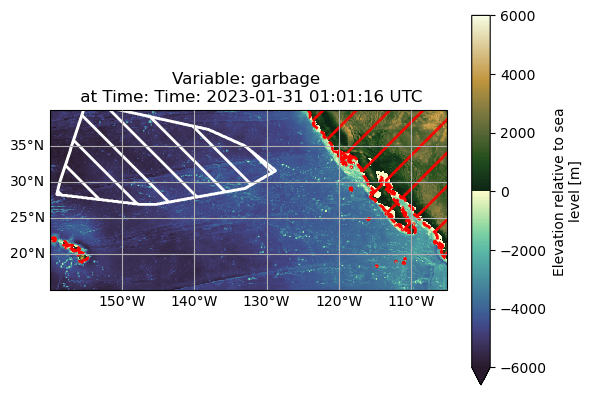

<Figure size 600x600 with 0 Axes>

In [32]:
# # West Coast
# lon_bnds = [-123, -105]
# lat_bnds = [18, 35]
# ax = b.plot_data_over_area(
#     x_interval=lon_bnds,
#     y_interval=lat_bnds,
#     return_ax=True,
# )
# ax = b.plot_mask_from_xarray(
#     xarray=b.get_data_over_area(x_interval=lon_bnds, y_interval=lat_bnds), ax=ax, masking_val=-150
# )
# plt.show()

# # Hawaii
# lon_bnds = [-160, -152]
# lat_bnds = [16, 23]
# ax = b.plot_data_over_area(
#     x_interval=lon_bnds,
#     y_interval=lat_bnds,
#     return_ax=True,
# )
# ax = b.plot_mask_from_xarray(
#     xarray=b.get_data_over_area(x_interval=lon_bnds, y_interval=lat_bnds), ax=ax, masking_val=-150
# )
# plt.show()
#fig = plt.figure(figsize=(24, 8))
ax = set_up_geographic_ax()
# Region 1
lon_bnds = [-160, -105]
lat_bnds = [15, 40]
ax = b.plot_data_over_area(
    x_interval=lon_bnds,
    y_interval=lat_bnds,
    return_ax=True,
    ax=ax
)
ax.get_figure().savefig("1.png", dpi=300)
ax = b.plot_mask_from_xarray(
    xarray=b.get_data_over_area(x_interval=lon_bnds, y_interval=lat_bnds), ax=ax, masking_val=-150
)
ax.get_figure().savefig("2.png", dpi=300)
ax = g.plot_mask_from_xarray(
    xarray=g.get_data_over_area(x_interval=lon_bnds, y_interval=lat_bnds),
    ax=ax,
)
ax.get_figure().savefig("3.png", dpi=300)


In [33]:
from scripts.safety.shipping_lanes import Graph, Edge, Node, plot_graph
ports = [
    ["Vancouver", 49.290, -123.11],
    ["Oakland", 37.804, -122.27],
    ["Los Angeles", 33.740, -118.28],
    ["Lazaro Cardenas", 17.927, -102.269],
    ["Honolulu", 21.309, -157.87],
    ["Tokyo", 35.619, 139.796],
    ["Shanghai", 31.220, 121.487],
    ["Singapore", 1.274, 103.802],
]
lanes = [
    ["Oakland", "Los Angeles"],
    ["Oakland", "Vancouver"],
    ["Los Angeles", "Honolulu", 2],
    ["Oakland", "Honolulu", 1],
    ["Tokyo", "Honolulu"],
    ["Los Angeles", "Singapore"],
    ["Oakland", "Shanghai"],
    ["Vancouver", "Shanghai"],
    ["Lazaro Cardenas", "Shanghai"],
]
graph = Graph()
for port in ports:
    graph.add_node(Node(*port))
for lane in lanes:
    graph.add_edge(Edge(*lane))

In [34]:
ax = plot_graph(graph, ax)
ax.get_figure().savefig("4.png", dpi=300)


In [36]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Dept <150m')
white_patch = mpatches.Patch(color='white', label='Garbage')
gold_patch = mpatches.Patch(color='gold', label='Shipping Lane')
ax.legend(handles=[red_patch, white_patch, gold_patch], loc="lower center")
ax.get_figure().savefig("5.png", dpi=300)


In [1]:
import xarray as xr
import sys

min_d_map_name = "ocean_navigation_simulator/package_data/bathymetry_and_garbage/bathymetry_distance_res_0.083_0.083_max_elevation_-150.nc"

min_d_map_loaded = xr.open_dataset(min_d_map_name)


In [2]:
pwd

'/home/andy/code/OceanPlatformControl'

In [7]:
min_d_map_loaded["distance"][1000, 500].data

array(295.153, dtype=float32)

### Heatmap of strandings

In [9]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [32]:
# Create toy data
config = {}
config["x_range"] = [-160, -105]
config["y_range"] = [15, 40]
samples = 10000
lon = np.random.uniform(*config["x_range"], samples)
lat = np.random.uniform(*config["y_range"], samples)
termination_reason_str = ["Stranded", "Other"]
termination_reason = np.random.choice(termination_reason_str, samples, p=[0.05, 0.95])
df = pd.DataFrame({"lat": lat, "lon": lon, "termination_reason": termination_reason})

In [92]:
df = pd.read_csv("data/results/safety_floating_10k_10d.csv")#safety_floating_10k_10d.csv") #safety_comparison_fc.csv

In [93]:
# Create 2d histogram of # stranding / # all in each 1 degree by 1 degree bin
x_edges = [i for i in range(config["x_range"][0], config["x_range"][1]+1)]
y_edges = [i for i in range(config["y_range"][0], config["y_range"][1]+1)]

H_s, xedges, yedges = np.histogram2d(df[df["termination_reason"]=="Stranded"]["x_0_lon"], df[df["termination_reason"]=="Stranded"]["x_0_lat"], bins=(x_edges, y_edges))
H_o, xedges_o, yedges_o = np.histogram2d(df[df["termination_reason"]!="Stranded"]["x_0_lon"], df[df["termination_reason"]!="Stranded"]["x_0_lat"], bins=(x_edges, y_edges))
H = H_s / (H_s + H_o)
# Transpose due to axis order
H = H.T

/tmp/ipykernel_27701/4284008789.py:7: RuntimeWarning: invalid value encountered in true_divide
  H = H_s / (H_s + H_o)


In [94]:
df["termination_reason"].value_counts()

Timeout          9655
Outside Arena     178
Stranded          167
Name: termination_reason, dtype: int64

/tmp/ipykernel_27701/3553921258.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax.get_figure().show()


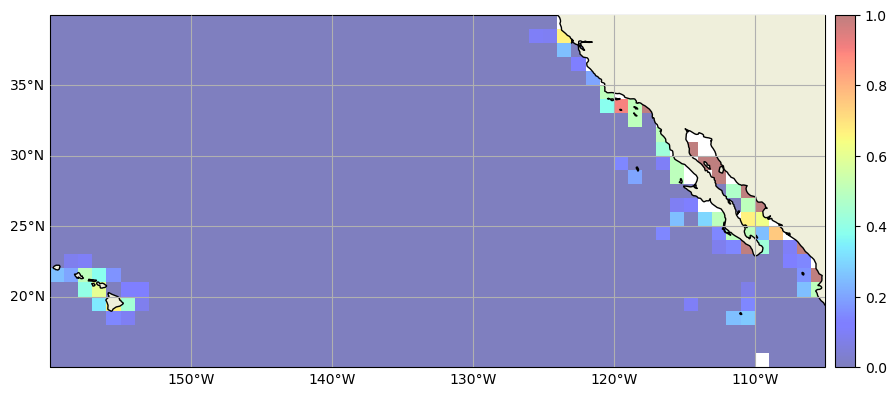

In [95]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_title("Time: " + datetime.fromtimestamp(time, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC'))

ax.add_feature(cfeature.LAND, zorder=3, edgecolor="black")
#ax.add_feature(cfeature.OCEAN, zorder=0)
grid_lines = ax.gridlines(draw_labels=True, zorder=5)
grid_lines.top_labels = False
grid_lines.right_labels = False
ax.axis(xmin=config["x_range"][0], xmax=config["x_range"][1])
ax.axis(ymin=config["y_range"][0], ymax=config["y_range"][1])

X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H, alpha = 0.5, cmap="jet")
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(cax=cax)
ax.get_figure().show()

### Scatterplot of Strandings

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_title("Time: " + datetime.fromtimestamp(time, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC'))

ax.add_feature(cfeature.LAND, zorder=3, edgecolor="black")
ax.add_feature(cfeature.OCEAN, zorder=0)
grid_lines = ax.gridlines(draw_labels=True, zorder=5)
grid_lines.top_labels = False
grid_lines.right_labels = False
ax.axis(xmin=config["x_range"][0], xmax=config["x_range"][1])
ax.axis(ymin=config["y_range"][0], ymax=config["y_range"][1])

colors = {"Stranded": "red", "Timeout": "green", "Outside Arena": "white", "run_failed":"purple", "Success":"gold"}
termination_reasons = ["Timeout", "Outside Arena", "run_failed", "Stranded", "Success"]

for reason in termination_reasons:#set(df["termination_reason"]):  
    plt.scatter(
    df[df['termination_reason'] == reason]["x_0_lon"], df[df['termination_reason'] == reason]["x_0_lat"], 
    c=colors[reason],marker="o",
            s=6,
            label=reason +" "+ str(sum(df["termination_reason"]==reason)))

#ax.scatter(df["x_T_lon"], df["x_T_lat"], c="green", marker="x", s=12, label="targets")
ax.legend()
# ax.get_figure().savefig(f"{analysis_folder}starts_and_targets.png")
ax.get_figure().show()

### Combine fc and hc

In [121]:
df_hc = pd.read_csv("data/results/safety_comparison_hc.csv")
df_hc.tail()
df_hc["mission_id"][0]

'safety_1k_10d_hc_2nd_safety_1k_10d_batch_seed_1000_0'

In [113]:
df_hc.head()

,Unnamed: 0,mission_id,setting,status,termination_reason,arrival_time,minDistance,x_0_lat,x_0_lon,mission_id_old
0,0,safety_1k_10d_hc_2nd_safety_1k_10d_batch_seed_...,hj_obs__NoObserver,finished_running,Success,180.167,0.000000,24.463924,-116.298515,safety_1k_10d_hc_2nd_safety_1k_10d_batch_seed_...
1,1,safety_1k_10d_hc_2nd_safety_1k_10d_batch_seed_...,hj_obs__NoObserver,finished_running,Timeout,NaN,0.030736,22.679064,-155.728363,safety_1k_10d_hc_2nd_safety_1k_10d_batch_seed_...
2,2,safety_1k_10d_hc_2nd_safety_1k_10d_batch_seed_...,hj_obs__NoObserver,finished_running,Success,212.833,0.000000,18.075535,-111.488518,safety_1k_10d_hc_2nd_safety_1k_10d_batch_seed_...
3,3,safety_1k_10d_hc_2nd_safety_1k_10d_batch_seed_...,hj_obs__NoObserver,finished_running,Success,154.333,0.000000,16.985481,-109.279686,safety_1k_10d_hc_2nd_safety_1k_10d_batch_seed_...
4,4,safety_1k_10d_hc_2nd_safety_1k_10d_batch_seed_...,hj_obs__NoObserver,finished_running,Success,156.000,0.000000,27.867901,-117.530067,safety_1k_10d_hc_2nd_safety_1k_10d_batch_seed_...


In [130]:
# Combine fc and hc experiments
df_hc = pd.read_csv("data/results/safety_comparison_hc.csv")
df_hc["mission_id_old"] = df_hc["mission_id"]
df_hc = df_hc.replace("hj_obs__NoObserver", "hj_obs_hc__NoObserver")
df_hc["mission_id"] = df_hc["mission_id"].apply(lambda x: pd.Series(str(x).split("safety_1k_10d_hc_2nd_")[-1]))
df_fc = pd.read_csv("data/results/safety_comparison_fc.csv")

df = pd.concat([df_hc, df_fc], ignore_index=True)
df = df.copy(deep=True)

In [131]:
assert len(set(df["mission_id"])) == 1200

In [135]:
# Only take finished runs that have all controllers
controllers = ["float__NoObserver", "hj_naive__NoObserver", "switch__NoObserver", "hj_obs__NoObserver", "hj_obs_hc__NoObserver"]
df_cm =  df[df["status"] == "finished_running"]
print(len(df_cm))
v = df_cm.mission_id.value_counts()
df_cm = df_cm[df_cm.mission_id.isin(v.index[v.eq(len(controllers))])]
print(len(df_cm))

5941
5855


### Functions

In [136]:
def calculate_stranding_matrix(df, normalize):
    df_cms = df_cm[df_cm["termination_reason"]=="Stranded"]
    cfs_matrix = np.zeros([len(controllers), len(controllers)])
    for i, controller_1 in enumerate(controllers):
        c1 = df_cms[df_cms.setting == controller_1].mission_id
        for j, controller_2 in enumerate(controllers):
            # Get the ids of missions that strand
            c2 = df_cms[df_cms.setting == controller_2].mission_id
            intersection = len(set(c1).intersection(set(c2)))
            cfs_matrix[i][j] = (intersection / len(c1)) if normalize else intersection
    return cfs_matrix

In [137]:
def plot_stranding_matrix(data, labels, output_filename, normalized):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
        normalized
    """
    normalized_str = " Normalized" if normalized else ""
    sns.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
    plt.title(f"Stranding{normalized_str}")
    sns.set(font_scale=1.4)
    ax = sns.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'}, fmt=".3g")
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set(ylabel="Stranded Missions of Controller", xlabel="Controller Used on Mission")
    #plt.savefig(output_filename + normalized_str.strip().lower() +".png" , bbox_inches='tight', dpi=300)
    #plt.close()
    plt.show()

In [140]:
def calculate_success_matrix(df, normalize):
    df_cm_suc = df_cm[df_cm["termination_reason"]=="Success"]
    cfs_matrix = np.zeros([len(controllers), len(controllers)])
    for i, controller_1 in enumerate(controllers):
        c1 = df_cm_suc[df_cm_suc.setting == controller_1].mission_id
        for j, controller_2 in enumerate(controllers):
            # Get the ids of missions that succeed
            c2 = df_cm_suc[df_cm_suc.setting == controller_2].mission_id
            intersection = len(set(c1).intersection(set(c2)))
            cfs_matrix[i][j] = (intersection / len(c1)) if normalize else intersection
    return cfs_matrix

In [143]:
def plot_success_matrix(data, labels, output_filename, normalized):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    normalized_str = " Normalized" if normalized else ""
    sns.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
    plt.title(f"Success{normalized_str}")
    sns.set(font_scale=1.4)
    ax = sns.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'}, fmt=".4g")
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set(ylabel="Successful Missions of Controller", xlabel="Controller Used on Mission")
    plt.show()
    # plt.savefig(output_filename + normalized_str.strip().lower() +".png" , bbox_inches='tight', dpi=300)
    # plt.close()

### C

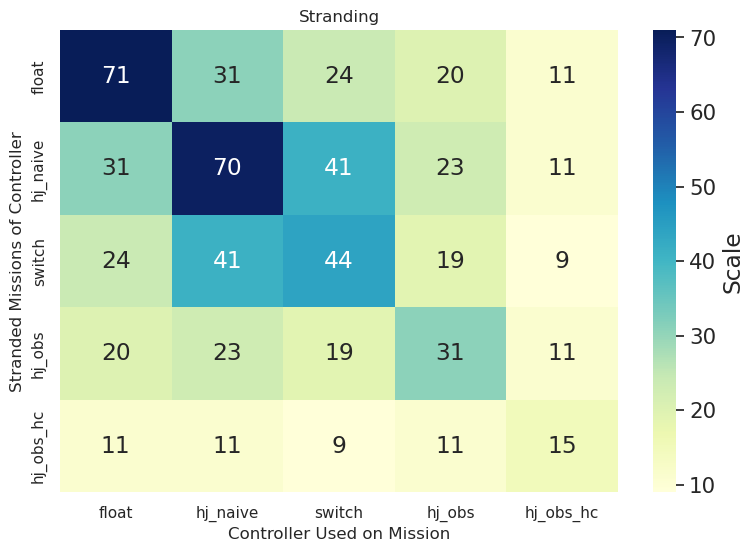

In [139]:
## Plot stranding matrix
normalize = False
labels = [c.split("__")[0] for c in controllers]
plot_stranding_matrix(calculate_stranding_matrix(df_cm, normalize), labels, "stranding_matrix", normalize)

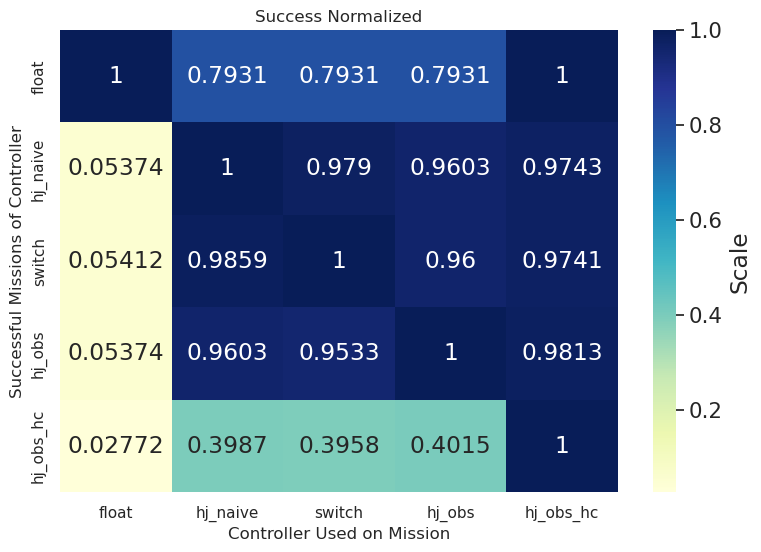

In [145]:
## Plot success matrix
normalize = True
labels = [c.split("__")[0] for c in controllers]
plot_success_matrix(calculate_success_matrix(df_cm, normalize), labels, "success_matrix", normalize)

In [ ]:
# Manual inspection last time
# All fail
all_fail = [
    "safety_1k_10d_batch_seed_1336_0",
    "safety_1k_10d_batch_seed_176_0",
    "safety_1k_10d_batch_seed_177_0",
    "safety_1k_10d_batch_seed_263_0",
]
hc_hc_fails =[
"safety_1k_10d_batch_seed_1336_0", # target too close to obstacle (probably in boundary around the visualized obstacle), super hard mission
" safety_1k_10d_batch_seed_176_0", # start in obstalce
" safety_1k_10d_batch_seed_177_0", # start too close to obstacle (probably in boundary around the visualized obstacle)
" safety_1k_10d_batch_seed_263_0", # target and start too close to obstacle (probably in boundary around the visualized obstacle)
" safety_1k_10d_batch_seed_603_0", # target in obstacle
" safety_1k_10d_batch_seed_655_0", # target too close to obstacle (probably in boundary around the visualized obstacle)
" safety_1k_10d_batch_seed_657_0", # start in obstalce
" safety_1k_10d_batch_seed_693_0", # start in obstacle
" safety_1k_10d_batch_seed_711_0", # target in obstacle
" safety_1k_10d_batch_seed_730_0", # target too close to obstacle (probably in boundary around the visualized obstacle)
" safety_1k_10d_batch_seed_780_0", # start too close to obstacle (probably in boundary around the visualized obstacle)
" safety_1k_10d_batch_seed_796_0", # target in obstacle
" safety_1k_10d_batch_seed_829_0", # target in obstacle
" safety_1k_10d_batch_seed_854_0", # target in obstacle
" safety_1k_10d_batch_seed_968_0", # start in obstalce
]
fc_fails_hc_okay_to_remove = [
"safety_1k_10d_batch_seed_1244_0", # target in obstacle
"safety_1k_10d_batch_seed_1259_0", # numerical errors (also for hc_hc)
"safety_1k_10d_batch_seed_1282_0", # target too close to obstacle (probably in boundary around the visualized obstacle), numerical errors for hc_hc
" safety_1k_10d_batch_seed_129_0", # target in obstacle
"safety_1k_10d_batch_seed_1345_0", # target in obstacle
" safety_1k_10d_batch_seed_289_0", # start too close to obstacle (probably in boundary around the visualized obstacle), numerical error 
" safety_1k_10d_batch_seed_312_0", # numerical erros
" safety_1k_10d_batch_seed_320_0", # target in obstacle
" safety_1k_10d_batch_seed_532_0", # target in obstacle, numerical errors
" safety_1k_10d_batch_seed_730_0", # target too close to obstacle (probably in boundary around the visualized obstacle)

]
fc_fails_hc_okay_to_keep = [
"safety_1k_10d_batch_seed_1002_0", # fc fail
"safety_1k_10d_batch_seed_1400_0", # fc fail
"safety_1k_10d_batch_seed_1409_0", # fc fail, interesting spiral trajectory
" safety_1k_10d_batch_seed_156_0", # fc fail, totally different direction
" safety_1k_10d_batch_seed_227_0", # fc fail, very tight case
" safety_1k_10d_batch_seed_292_0", # fc fail, baja california. hc timeout
" safety_1k_10d_batch_seed_357_0", # fc fail
" safety_1k_10d_batch_seed_427_0", # fc_fail
" safety_1k_10d_batch_seed_814_0", # fc fail, very small space baja california
" safety_1k_10d_batch_seed_881_0", # fc fail
" safety_1k_10d_batch_seed_906_0", # fc fail. hc has numerical erros (min -3.)
]

# fc_fails_hc_not_full_list = [
# "safety_1k_10d_batch_seed_1002_0", # fc fail
# "safety_1k_10d_batch_seed_1244_0", # target in obstacle
# "safety_1k_10d_batch_seed_1259_0", # numerical errors (also for hc_hc)
# "safety_1k_10d_batch_seed_1282_0", # target too close to obstacle (probably in boundary around the visualized obstacle), numerical errors for hc_hc
# " safety_1k_10d_batch_seed_129_0", # target in obstacle
# "safety_1k_10d_batch_seed_1345_0", # target in obstacle
# "safety_1k_10d_batch_seed_1400_0", # fc fail
# "safety_1k_10d_batch_seed_1409_0", # fc fail, interesting spiral trajectory
# " safety_1k_10d_batch_seed_156_0", # fc fail, totally different direction
# " safety_1k_10d_batch_seed_227_0", # fc fail, very tight case
# " safety_1k_10d_batch_seed_289_0", # start too close to obstacle (probably in boundary around the visualized obstacle), numerical error 
# " safety_1k_10d_batch_seed_292_0", # fc fail, baja california. hc timeout
# " safety_1k_10d_batch_seed_312_0", # numerical erros
# " safety_1k_10d_batch_seed_320_0", # target in obstacle
# " safety_1k_10d_batch_seed_357_0", # fc fail
# " safety_1k_10d_batch_seed_427_0", # fc_fail
# " safety_1k_10d_batch_seed_532_0", # target in obstacle, numerical errors
# " safety_1k_10d_batch_seed_730_0", # target too close to obstacle (probably in boundary around the visualized obstacle)
# " safety_1k_10d_batch_seed_814_0", # fc fail, very small space baja california
# " safety_1k_10d_batch_seed_881_0", # fc fail
# " safety_1k_10d_batch_seed_906_0", # fc fail. hc has numerical erros (min -3.)
# ]

In [147]:
# Get missions where all strand
df_cms = df_cm[df_cm["termination_reason"]=="Stranded"]
len(df_cms)
v = df_cms.mission_id.value_counts()
df_all_strand = df_cms[df_cms.mission_id.isin(v.index[v.eq(len(controllers))])]
print(len(set(df_all_strand.mission_id)))
for i in sorted(set(df_all_strand.mission_id)):
    print(i)

4
safety_1k_10d_batch_seed_1336_0
safety_1k_10d_batch_seed_176_0
safety_1k_10d_batch_seed_177_0
safety_1k_10d_batch_seed_263_0


In [146]:
for c in controllers:
    print(c.split("__")[0])
    print(df_cm[df_cm["setting"] == c]["termination_reason"].value_counts())

float
Timeout          1049
Stranded           71
Success            29
Outside Arena      22
Name: termination_reason, dtype: int64
hj_naive
Timeout          661
Success          428
Stranded          70
Outside Arena     12
Name: termination_reason, dtype: int64
switch
Timeout          689
Success          425
Stranded          44
Outside Arena     13
Name: termination_reason, dtype: int64
hj_obs
Timeout          699
Success          428
Stranded          31
Outside Arena     13
Name: termination_reason, dtype: int64
hj_obs_hc
Success          1046
Timeout           103
Stranded           15
Outside Arena       7
Name: termination_reason, dtype: int64


### Confusion Matrix Success